In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [2]:
ls -al

total 62368
drwxr-xr-x  3 jerome jerome    4096 sept. 27 07:53 ./
drwxr-xr-x 25 jerome jerome    4096 sept. 17 18:23 ../
-rw-r--r--  1 jerome jerome  518218 févr. 26  2017 18mm.jpg
-rw-r--r--  1 jerome jerome 3864200 sept. 27 07:50 corrections_gpu.ipynb
-rw-r--r--  1 jerome jerome 2376055 sept. 17 17:28 g1.jpg
-rw-r--r--  1 jerome jerome 2261608 sept. 17 17:28 g2.jpg
-rw-r--r--  1 jerome jerome 8660453 sept. 17 17:28 g3.jpg
-rw-------  1 jerome jerome 1172747 févr. 26  2017 grid-18mm.ipynb
-rw-------  1 jerome jerome 1853587 mars  20  2017 grid-18mm-raw.ipynb
-rw-r--r--  1 jerome jerome 4408397 sept. 26 21:10 grid-8M.jpg
-rw-r--r--  1 jerome jerome 5251991 sept. 27 07:53 grid_8M_ortho.ipynb
-rw-r--r--  1 jerome jerome 4299391 sept. 26 21:10 grid-8M_v2.jpg
-rw-r--r--  1 jerome jerome 1273545 sept. 17 17:28 grid.ipynb
-rw-r--r--  1 jerome jerome   54240 sept. 17 17:28 grid.png
-rw-r--r--  1 jerome jerome 4327928 sept. 26 21:10 grid_v2_8M_ortho_auto.jpg
-rw-r--r--  1 jerome jerome 4328742

In [3]:
from PIL import Image
path = "grid_v3_8M_ortho_auto.jpg"
raw = numpy.dot(numpy.asarray(Image.open(path)), [0.299,0.587, 0.114])
print(raw)

[[ 87.913  88.913  87.728 ...,  40.86   35.942  35.942]
 [ 89.201  89.201  89.016 ...,  43.86   35.17   36.17 ]
 [ 87.891  86.891  83.005 ...,  36.729  37.039  45.811]
 ..., 
 [ 55.181  55.181  49.811 ...,  46.805  48.794  47.794]
 [ 52.953  52.953  56.181 ...,  41.794  46.164  49.164]
 [ 53.953  54.953  59.181 ...,  43.794  43.164  46.164]]


<IPython.core.display.Javascript object>


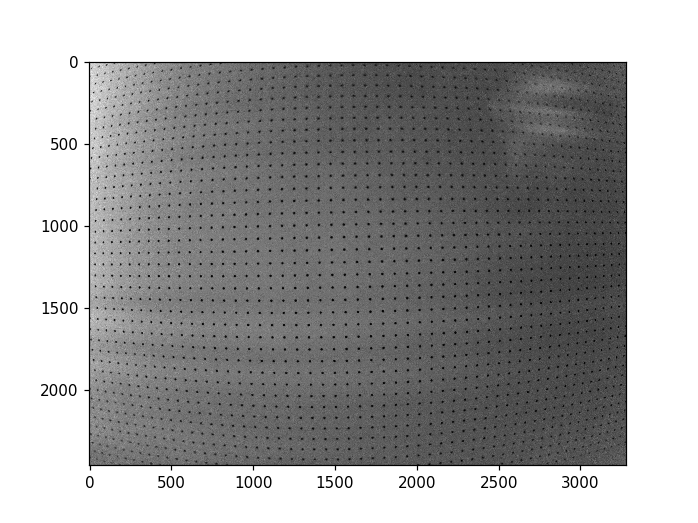

In [4]:
f, ax = subplots()
ax.imshow(raw, cmap="gray")

<IPython.core.display.Javascript object>


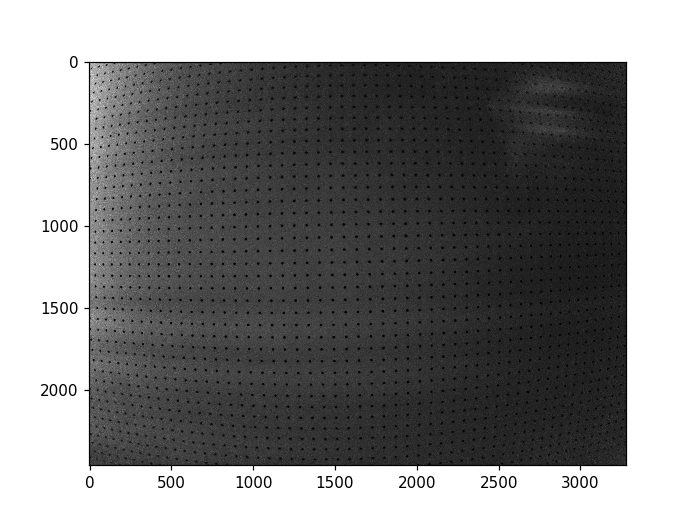

In [5]:
v = raw/255.0
m = (v > 0.04045)
raw_lin = numpy.empty_like(v)
raw_lin = v / 12.92
raw_lin[m] = (((v + 0.055) / 1.055) ** 2.4)[m]
f, ax = subplots()
ax.imshow(raw_lin, cmap="gray")

In [6]:
width=83

try:
    from silx.opencl import medfilt
except:
    print("using scipy")
    from scipy.ndimage import filters
    %time flat = filters.median_filter(raw, width, mode="nearest")                     
else:
    print("using silx")
    %time flat = medfilt.medfilt2d(raw, width)                     
#flat = filters.maximum_filter(raw, width, mode="nearest")   



using silx
CPU times: user 2min 54s, sys: 38.3 s, total: 3min 33s
Wall time: 3min 33s


<IPython.core.display.Javascript object>


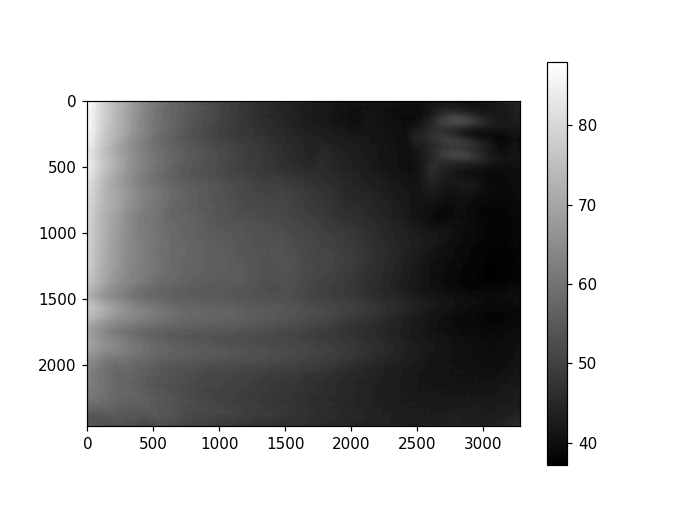

In [7]:
figure()
imshow(flat, cmap="gray")
colorbar()

<IPython.core.display.Javascript object>


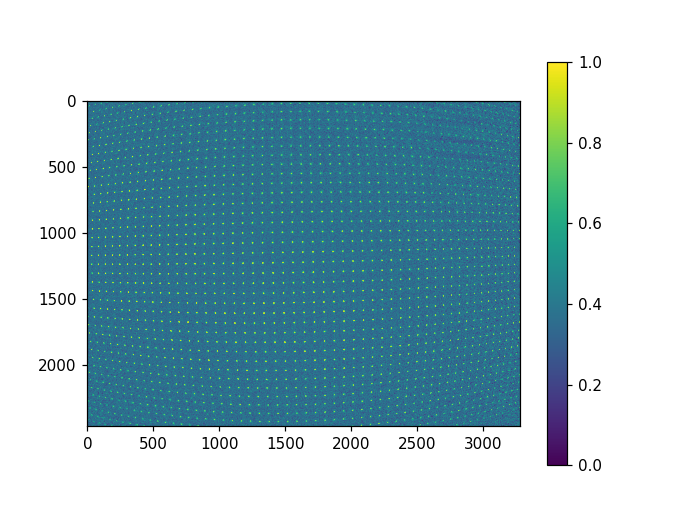

In [8]:
figure()
fcor = raw/flat
img = (fcor.max() - fcor)/(fcor.max()-fcor.min())
imshow(img)
colorbar()

<IPython.core.display.Javascript object>


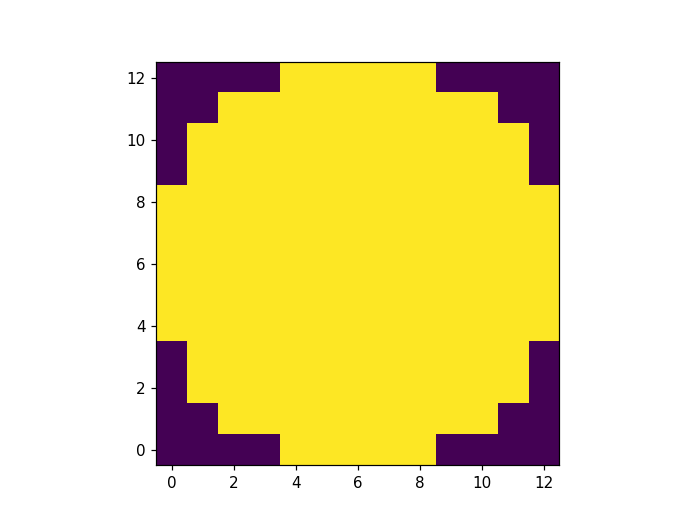

In [9]:
size = 13 #Odd of course
center = (size-1)//2
y, x = numpy.ogrid[-center:center+1,-center:center+1]
r2 = x*x + y*y
kernel = (r2<=(center+0.5)**2).astype(float)
kernel /= kernel.sum()
figure()
imshow(kernel, interpolation="nearest", origin="lower")

In [10]:
from scipy import ndimage, signal
cnv = signal.convolve2d(img, kernel, mode="same")

In [11]:
#Check that size is unchanged.
print(img.shape) 
print(cnv.shape)

(2464, 3280)
(2464, 3280)


<IPython.core.display.Javascript object>


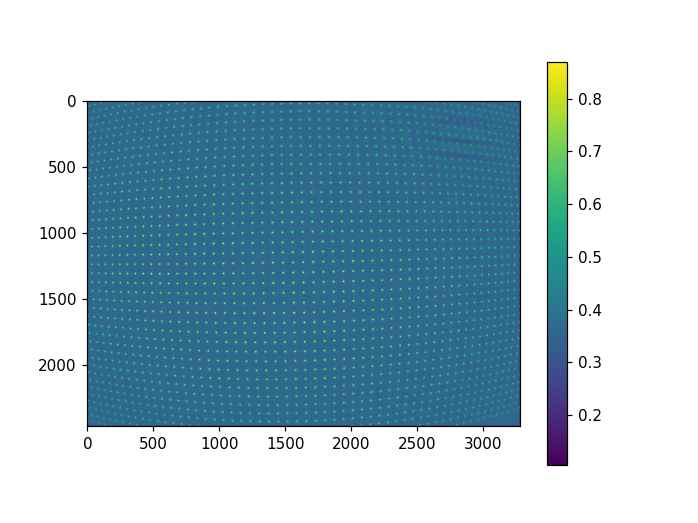

In [12]:
#Check the image still looks the same. it is just supposed to be smoother.
figure()
imshow(cnv, interpolation="nearest")
colorbar()

In [13]:
mini = (kernel>0).sum()
print("Number of points in the kernel: %s"%mini)

Number of points in the kernel: 137


In [14]:
try: #depends if the version of pyFAI you are using
    from pyFAI.watershed import InverseWatershed
except:
    from pyFAI.ext.watershed import InverseWatershed
    #Version of pyFAI newer than feb 2016
iw = InverseWatershed(cnv)
iw.init()
iw.merge_singleton()
all_regions = set(iw.regions.values())
regions = [i for i in all_regions if i.size>mini]

print("Number of region segmented: %s"%len(all_regions))
print("Number of large enough regions : %s"%len(regions))

Number of region segmented: 181537
Number of large enough regions : 4137


<IPython.core.display.Javascript object>


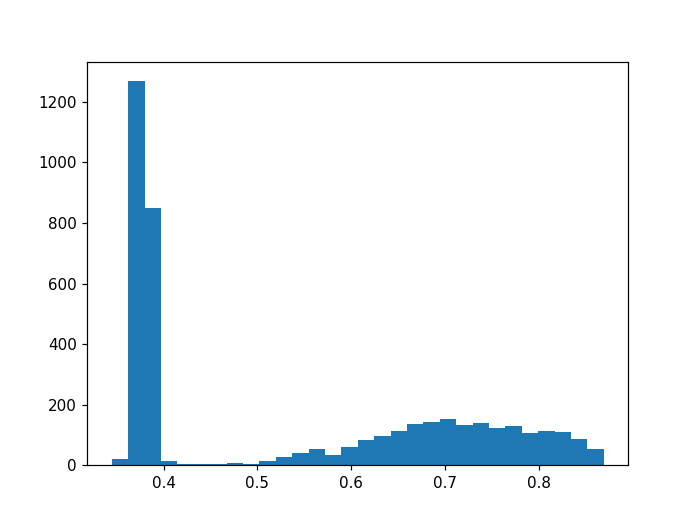

(array([   22.,  1267.,   850.,    14.,     6.,     3.,     3.,     8.,
            5.,    14.,    27.,    41.,    55.,    34.,    60.,    84.,
           96.,   115.,   137.,   142.,   153.,   134.,   140.,   123.,
          131.,   108.,   113.,   110.,    88.,    54.]),
 array([ 0.34482136,  0.36230113,  0.37978089,  0.39726065,  0.41474041,
         0.43222018,  0.44969994,  0.4671797 ,  0.48465946,  0.50213923,
         0.51961899,  0.53709875,  0.55457851,  0.57205828,  0.58953804,
         0.6070178 ,  0.62449756,  0.64197733,  0.65945709,  0.67693685,
         0.69441661,  0.71189637,  0.72937614,  0.7468559 ,  0.76433566,
         0.78181542,  0.79929519,  0.81677495,  0.83425471,  0.85173447,
         0.86921424]),
 <a list of 30 Patch objects>)

In [15]:
s = [i.maxi for i in regions]
figure()
hist(s, 30)
#Look for the maximum value in each region to be able to segment accordingly


In [16]:
thres= 0.45
peaks = [(i.index//img.shape[-1], i.index%img.shape[-1]) for i in regions if (i.maxi)>thres]
print("Number of remaining peaks: %s"%len(peaks))

Number of remaining peaks: 1974


<IPython.core.display.Javascript object>


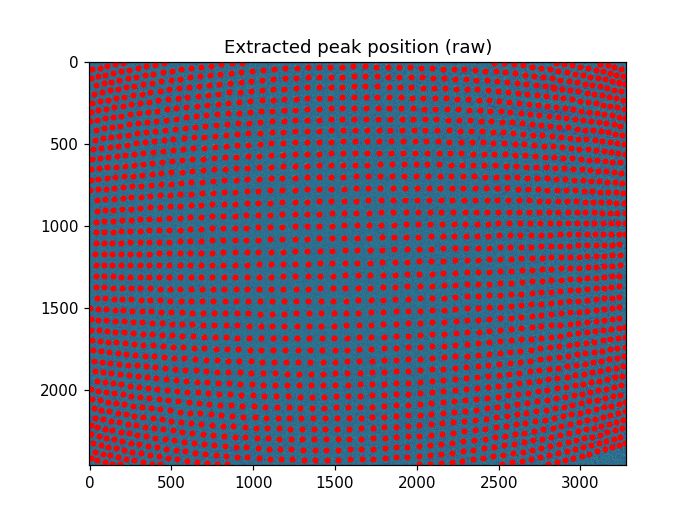

Raw peak coordinate:
[(1747, 702), (1147, 1712), (1576, 103), (1305, 3238), (984, 3273), (2241, 1297), (966, 196), (487, 2335), (1117, 3041), (1307, 1333)]


In [17]:
figure()
imshow(img, interpolation="nearest")
peaks_raw = numpy.array(peaks)
plot(peaks_raw[:,1], peaks_raw[:, 0], ".r")
title("Extracted peak position (raw)")
print("Raw peak coordinate:")
print(peaks[:10])

In [18]:
try:
    from pyFAI.bilinear import Bilinear
except:
    from pyFAI.ext.bilinear import Bilinear
bl = Bilinear(cnv)

<IPython.core.display.Javascript object>


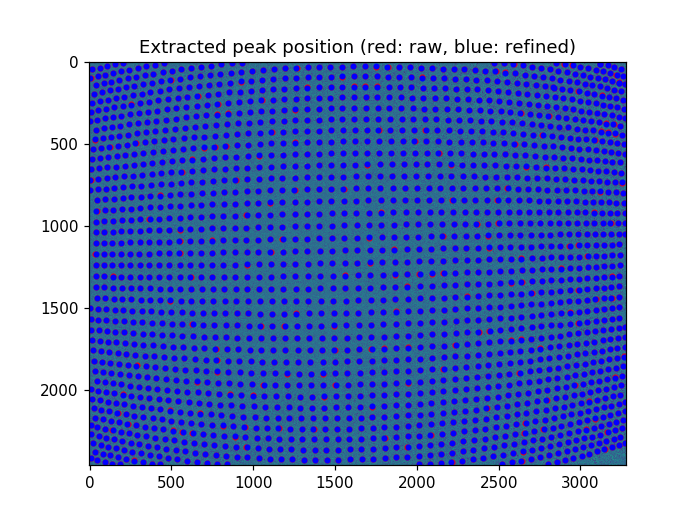

Refined peak coordinate:
[(1747.4108150601387, 702.0783519223332), (1146.82444255054, 1711.5164189338684), (1575.7038927674294, 103.55545037984848), (1305.4111674427986, 3237.7210808098316), (984.2263115048409, 3273.356916934252), (2240.5656319260597, 1296.4643921852112), (965.7268094420433, 196.1694917678833), (487.4093797802925, 2335.0100306468084), (1117.4398011565208, 3041.081402026117), (1306.9002153128386, 1333.4076447188854)]


In [19]:
figure()
ref_peaks = [bl.local_maxi(p) for p in peaks_raw]
imshow(img, interpolation="nearest")
peaks_ref = numpy.array(ref_peaks)
plot(peaks_raw[:,1], peaks_raw[:, 0], ".r")
plot(peaks_ref[:,1],peaks_ref[:, 0], ".b")
title("Extracted peak position (red: raw, blue: refined)")
print("Refined peak coordinate:")
print(ref_peaks[:10])

In [20]:
# Nota, pyFAI uses **C-coordinates** so they come out as (y,x) and not the usual (x,y). 
# This notation helps us to remind the order
yx = numpy.array(ref_peaks)

In [21]:
# pairwise distance calculation using scipy.spatial.distance_matrix
from scipy.spatial import distance_matrix
dist = distance_matrix(peaks_ref, peaks_ref)

<IPython.core.display.Javascript object>


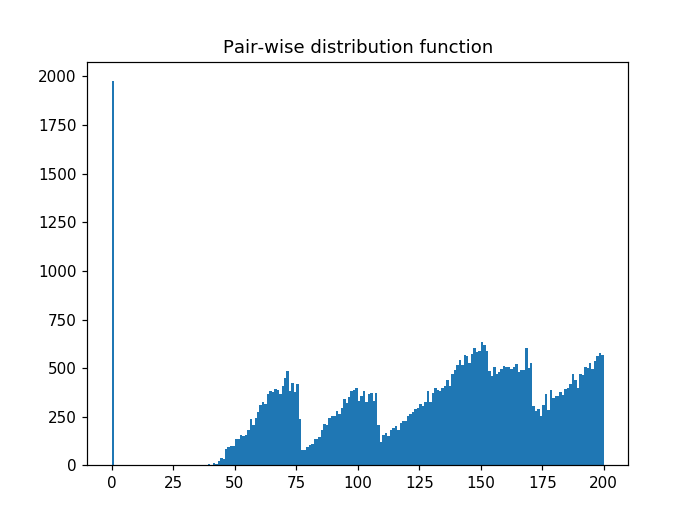

In [22]:
figure()
hist(dist.ravel(), 200, range=(0,200))
title("Pair-wise distribution function")

In [23]:
#We define here a data-type for each peak (called center) with 4 neighbours (called north, east, south and west). 
point_type = np.dtype([('center_y', float), ('center_x', float),
                        ('east_y', float), ('east_x', float),
                        ('west_y', float), ('west_x', float),
                        ('north_y', float), ('north_x', float),
                        ('south_y', float), ('south_x', float)])

neig = np.logical_and(dist>10.0, dist<78)
valid = (neig.sum(axis=-1)==4).sum()
print("There are %i control point with exactly 4 first neigbours"%valid)
# This initializes an empty structure to be populated
point = numpy.zeros(valid, point_type)

There are 1312 control point with exactly 4 first neigbours


In [24]:
#Populate the structure: we use a loop as it loops only over 1200 points 
h=-1
for i, center in enumerate(peaks_ref):
    if neig[i].sum()!=4: continue
    h+=1
    point[h]["center_y"],point[h]["center_x"] = center
    for j in ((0,1),(0,-1),(1,0),(-1,0)):
        tmp = []
        for k in numpy.where(neig[i]):
            curr = yx[k]
            tmp.append(dot(curr-center,j))
            l = argmax(tmp)
            y, x = peaks_ref[numpy.where(neig[i])][l]
            if j==(0,1):point[h]["east_y"], point[h]["east_x"] = y, x
            elif j==(0,-1):point[h]["west_y"], point[h]["west_x"] = y, x
            elif j==(1,0): point[h]["north_y"],point[h]["north_x"] = y, x
            elif j==(-1,0):point[h]["south_y"],point[h]["south_x"] = y, x
all_points = point

<IPython.core.display.Javascript object>


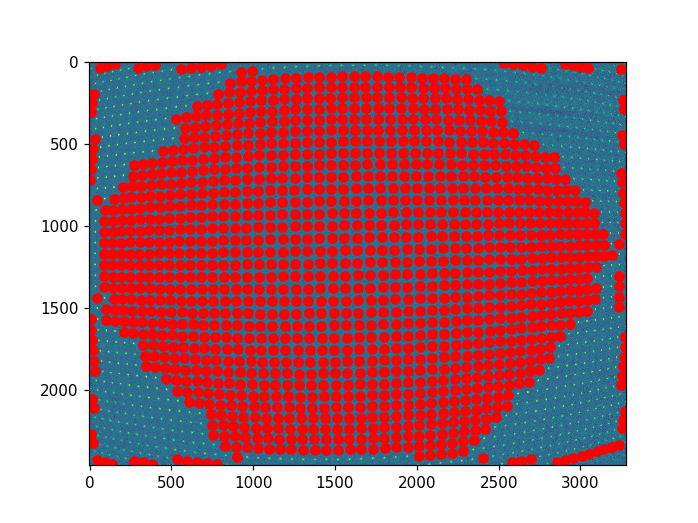

In [25]:
figure()
ref_peaks = [bl.local_maxi(p) for p in peaks_raw]
imshow(img, interpolation="nearest")
#peaks_ref = numpy.array(ref_peaks)
plot(point[:]["center_x"], point[:]["center_y"], "or")


The guessed center is at (1640, 1232)
1052


<IPython.core.display.Javascript object>


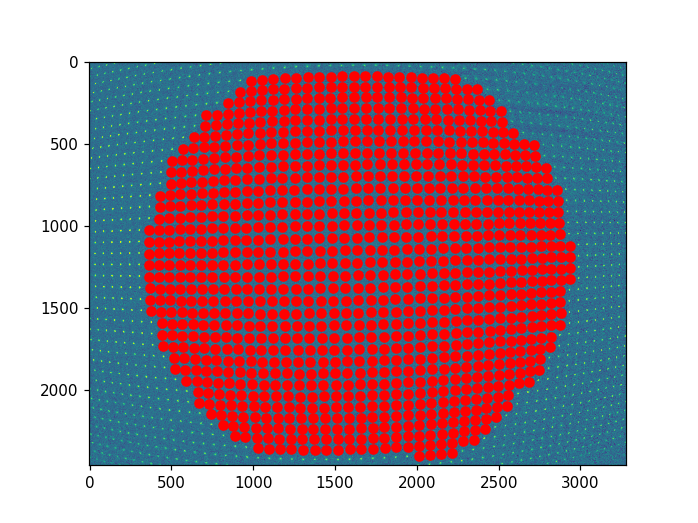

In [26]:
Cy, Cx = tuple(i//2 for i in cnv.shape) #detector center
print("The guessed center is at (%s, %s)"%(Cx, Cy))

t2 = 1300**2
point_mask = numpy.array([(i["center_x"]-Cx)**2+ (i["center_y"]-Cy)**2<t2 for i in point])
print(point_mask.sum())
figure()
ref_peaks = [bl.local_maxi(p) for p in peaks_raw]
imshow(img, interpolation="nearest")
point = point[point_mask]
plot(point[:]["center_x"], point[:]["center_y"], "or")


In [27]:
#Select the initial guess for the center:

#Most intense peak:
#m = max([i for i in regions], key=lambda i:i.maxi)
#Cx, Cy = m.index%img.shape[-1],m.index//img.shape[-1]
#Cx, Cy = point["center_x"].mean(), point["center_y"].mean() #Centroid of all points
#Cx, Cy = 734, 1181 #beam center
Cy, Cx = tuple(i//2 for i in cnv.shape) #detector center
print("The guessed center is at (%s, %s)"%(Cx, Cy))

#Get the nearest point from centroid:
d2 = ((point["center_x"]-Cx)**2+(point["center_y"]-Cy)**2)
best = d2.argmin()
Op = point[best]
Ox, Oy = Op["center_x"], Op["center_y"]

print("The center is at (%s, %s)"%(Ox, Oy))
#Calculate the average vector along the 4 main axes 
Xx = (point[:]["east_x"] - point[:]["center_x"]).mean()
Xy = (point[:]["east_y"] - point[:]["center_y"]).mean()
Yx = (point[:]["north_x"] - point[:]["center_x"]).mean()
Yy = (point[:]["north_y"] - point[:]["center_y"]).mean()

print("The X vector is is at (%s, %s)"%(Xx, Xy))
print("The Y vector is is at (%s, %s)"%(Yx, Yy))


The guessed center is at (1640, 1232)
The center is at (1636.76433425, 1225.01829287)
The X vector is is at (69.1918243113, -1.45018054944)
The Y vector is is at (1.40098639746, 69.9620792091)


In [28]:
print("X has an angle of %s deg"%rad2deg(arctan2(Xy, Xx)))
print("Y has an angle of %s deg"%rad2deg(arctan2(Yy, Yx)))
print("The XY angle is %s deg"%rad2deg(arctan2(Yy, Yx)-arctan2(Xy, Xx)))


X has an angle of -1.20067743206 deg
Y has an angle of 88.8528088107 deg
The XY angle is 90.0534862428 deg


In [29]:
from collections import namedtuple, OrderedDict
Peak = namedtuple("Peak", ('center_y', 'center_x'))
Coord = namedtuple("Coord", ('X', 'Y'))
dicopt = OrderedDict()

def nearest(pty,ptx):
    d2 = (point[:]['center_y']-pty)**2 +  (point[:]['center_x']-ptx)**2
    m = d2.argmin()
    if d2[m]<1:
        return point[m]

def add_nei(pt, coord):
    dicopt[coord]= Peak(pt[0],pt[1])
    east = nearest(pt[2],pt[3])
    east_coord = Coord(coord[0]+1, coord[1])
    if east is not None:
        if east_coord not in dicopt:
            add_nei(east, east_coord)
    else:
        dicopt[east_coord] = Peak(pt[2],pt[3])

    west = nearest(pt[4],pt[5])
    west_coord = Coord(coord[0]-1, coord[1])
    if west is not None:
        if west_coord not in dicopt:
            add_nei(west, west_coord)
    else:
        dicopt[west_coord] = Peak(pt[4],pt[5])

    south = nearest(pt[6],pt[7])
    south_coord = Coord(coord[0], coord[1]+1)
    if south is not None:
        if south_coord not in dicopt:
            add_nei(south, south_coord)
    else:
        dicopt[south_coord] = Peak(pt[6],pt[7])

    north = nearest(pt[8],pt[9])
    north_coord = Coord(coord[0], coord[1]-1)
    if north is not None:
        if north_coord not in dicopt:
            add_nei(north, north_coord)
    else:
        dicopt[north_coord] = Peak(pt[8],pt[9])


add_nei(Op, Coord(0,0))
print(len(dicopt))

1162


In [30]:
dataset = numpy.zeros((len(dicopt), 4))
for idx, (k,v) in enumerate(dicopt.items()):
    if idx<10:
        print("%s --> %s"%(k,v))
    dataset[idx,0] = k[0]
    dataset[idx,1] = k[1]
    dataset[idx,2] = v[1]
    dataset[idx,3] = v[0]
print(dataset[:5])

Coord(X=0, Y=0) --> Peak(center_y=1225.0182928740978, center_x=1636.7643342465162)
Coord(X=1, Y=0) --> Peak(center_y=1223.4046708345413, center_x=1713.0962595045567)
Coord(X=2, Y=0) --> Peak(center_y=1221.8807255849242, center_x=1789.2129336446524)
Coord(X=3, Y=0) --> Peak(center_y=1220.1876456141472, center_x=1864.7664056867361)
Coord(X=4, Y=0) --> Peak(center_y=1218.5248256027699, center_x=1940.0072346311063)
Coord(X=5, Y=0) --> Peak(center_y=1216.7395364642143, center_x=2014.8429729789495)
Coord(X=6, Y=0) --> Peak(center_y=1214.8344674110413, center_x=2088.5416326224804)
Coord(X=7, Y=0) --> Peak(center_y=1213.1084712967277, center_x=2161.7065919041634)
Coord(X=8, Y=0) --> Peak(center_y=1211.1387990266085, center_x=2233.7796155959368)
Coord(X=9, Y=0) --> Peak(center_y=1209.3662219047546, center_x=2304.2035662829876)
[[  0.00000000e+00   0.00000000e+00   1.63676433e+03   1.22501829e+03]
 [  1.00000000e+00   0.00000000e+00   1.71309626e+03   1.22340467e+03]
 [  2.00000000e+00   0.00000

In [31]:
def rotate(arg, data=dataset): 
    "Convert the XY (integrers) parameters in xy, pixel coordinates, without distortion, only rotation+translation"
    xc, yc, Xx, Yx, Xy, Yy, Xc, Yc = arg
    XYc = numpy.atleast_2d(numpy.array((Xc, Yc)))
    XY = (data[:,:2]-XYc).T
    #R = numpy.array([[Xx, Xy],[Yx, Yy]])
    R = numpy.array([[Xx, Yx], [Xy, Yy]])
    xyc = numpy.atleast_2d(numpy.array((xc, yc)))
    res = dot(R, XY).T + xyc
    return res 

def error_rot(arg, data=dataset):
    w = rotate(arg, data=data) 
    e = data[:,2:]
    d2 = (w-e)**2
    return numpy.sum(d2)

w = rotate([Ox, Oy, Xx, Yx, Xy, Yy, 0, 0], dataset) 
for i in range(5):
    print("%s %s "%(dataset[i,:], w[i,:]))

#mask = numpy.where(numpy.logical_and(abs(dataset[:,0])<5, abs(dataset[:,1])<5))
#print(mask[0], len(mask[0]))
#for i in mask[0]:
#    print(w[i], dataset[i,2:], ((w[i]-dataset[i,2:])**2).sum())
print(((w-dataset[:,2:])**2).sum())

print(error_rot((Ox, Oy, Xx,Yx, Xy, Yy, 0, 0)))
    
from scipy.optimize import minimize
res0 = [Ox, Oy, Xx, Yx, Xy, Yy, 0, 0]
print(res0)
bounds = [(1500,1800),(1000, 1500), (60,100), (-5, 5), (-5, 5), (60,100), 
          (-10, 10),(-10, 10)]
print(res0)
print(error_rot(res0))
res1  = minimize(error_rot, res0, bounds=bounds)
print(res1)
res1 = res1.x

[    0.             0.          1636.76433425  1225.01829287] [ 1636.76433425  1225.01829287] 
[  1.00000000e+00   0.00000000e+00   1.71309626e+03   1.22340467e+03] [ 1705.95615856  1223.56811232] 
[    2.             0.          1789.21293364  1221.88072558] [ 1775.14798287  1222.11793178] 
[    3.             0.          1864.76640569  1220.18764561] [ 1844.33980718  1220.66775123] 
[    4.             0.          1940.00723463  1218.5248256 ] [ 1913.53163149  1219.21757068] 
1409390.12792
1409390.12792
[1636.7643342465162, 1225.0182928740978, 69.19182431129137, 1.400986397457433, -1.4501805494361497, 69.962079209115302, 0, 0]
[1636.7643342465162, 1225.0182928740978, 69.19182431129137, 1.400986397457433, -1.4501805494361497, 69.962079209115302, 0, 0]
1409390.12792
      fun: 724148.49161177524
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([  0.16298145,   0.10477379,  23.6555934 ,  13.76029104,
       -12.22360879, -28.63816917, -12.00241968,  -8.17235559])

In [32]:
from scipy.optimize import minimize

def wrapd1(arg, data=dataset):
    d = data[:,2:]
    
    c = numpy.atleast_2d(numpy.array((arg[0], arg[1])))
    r1 =((d - c)**2).sum(axis=-1)
    r2 = numpy.atleast_2d(r1).T
    #for i in zip(dataset, r2, range(10)):
    #    print(i[0], i[1])
    K1 = arg[8]*1e-9
    return c + (d-c)/(1.0+K1*r2)

def unwrapd1(arg, data=dataset):
    "convert indexes to distorted position"
    u = rotate(arg[:8], data=data) 
    c = numpy.atleast_2d(numpy.array((arg[0], arg[1])))
    r1 =((u - c)**2).sum(axis=-1)
    r2 = numpy.atleast_2d(r1).T
    #for i in zip(dataset, r2, range(10)):
    #    print(i[0], i[1])
    K1 = arg[8]*1e-9
    return c + (u - c)*(1+K1*r2)
    #return c + (d-c)/(1.0+K1*r2)


def errord1(arg, data=dataset):
    w = wrapd1(arg, data=data) 
    u = rotate(arg[:8]) 
    d2 = (w-u)**2
    return numpy.sum(d2)

def errord1u(arg, data=dataset):
    ex = unwrapd1(arg, data=data) 
    di = data[:,2:]
    d2 = (ex-di)**2
    return numpy.sum(d2)


res0d1=list(res1)+[0]
print(errord1(res0d1))

boundsd1 = [(i,i) for i in res1] + [(-10,10)]

#Does not work very well
res1d1  = minimize(errord1, res0d1, bounds=boundsd1)
print(res1d1)

res1d1u  = minimize(errord1u, res0d1, bounds=boundsd1)
print(res1d1u)

bounds2d1 = bounds + [(-100,100)]
print(len(bounds2d1), len(res1d1.x))

res2d1  = minimize(errord1, res1d1.x, bounds=bounds2d1)
print(res2d1)

res2d1u  = minimize(errord1u, res1d1u.x, bounds=bounds2d1)
print(res2d1u)

#bounds[6] = res1[6], res1[6]
#bounds[7] = res1[7], res1[7]
#bounds[11] = -1.1,1.1
#bounds[10] = -1.1,1.1
#print(errord1(res1d1.x))
#res2  = minimize(error, res1, bounds=bounds)
#print(res2)

724148.491612
      fun: 667668.61113953218
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([   -295.1361239 ,    -417.88443923, -117051.32201314,
         -2067.25671887,    2231.82141781,  -94874.80856478,
         29849.77327287,   29371.88837677,       0.        ])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 60
      nit: 5
   status: 0
  success: True
        x: array([  1.63016132e+03,   1.21415051e+03,   7.10242214e+01,
         1.44657175e+00,  -1.45099771e+00,   7.15506676e+01,
        -1.13902520e-02,  -1.03336393e-01,  -5.51971748e+00])
      fun: 648155.34816823702
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -6.40202779e+02,  -4.43158206e+02,  -1.33678294e+05,
        -2.57225474e+03,   2.27440614e+03,  -1.07448723e+05,
         5.53901191e+04,   3.18444800e+04,   1.16415322e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 50
      nit: 3
   status: 0
  success:

<IPython.core.display.Javascript object>


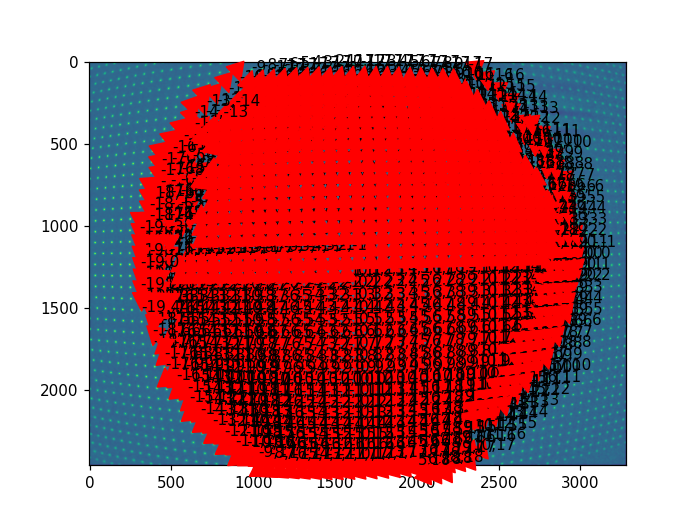

In [33]:
fitted = unwrapd1(res2d1u.x)
f = figure()
ax = f.add_subplot(1,1,1)
ax.imshow(cnv, interpolation="nearest")
for k, ds, w in zip(dicopt, dataset, fitted):
    ax.annotate("%i,%i"%k, xy=ds[2:], xytext=w,
                arrowprops=dict(facecolor='red', edgecolor='red'))

729
(1162, 729)


<IPython.core.display.Javascript object>


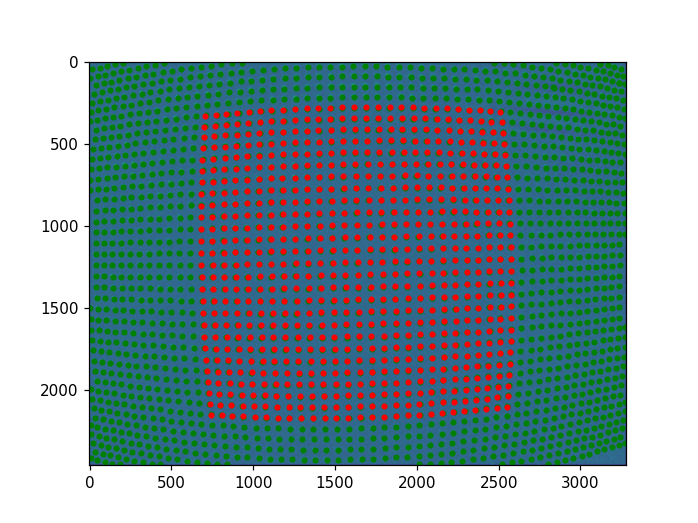

In [34]:
import itertools
all_idx_12 = numpy.array(list(itertools.product(range(-13, 14),range(-13,14))),dtype="float64")
print(len(all_idx_12))
fitted_12 = unwrapd1(res2d1u.x, data=all_idx_12)
print(len(dataset), len(fitted_12))
f,ax = subplots()
ax.imshow(cnv, interpolation="nearest")
plot(peaks_ref[:,1],peaks_ref[:, 0], ".g")
plot(fitted_12[:,0], fitted_12[:,1],".r")

(729, 1974)
729
10836.4121176
(0, array([ -13.        ,  -13.        ,  713.47978306,  324.65622067]), array([ 705.6626624 ,  329.34094632]))
(1, array([ -13.        ,  -12.        ,  708.23766766,  389.66441789]), array([ 701.08697831,  393.63777222]))
(2, array([ -13.        ,  -11.        ,  702.08697996,  453.92149493]), array([ 697.00558765,  459.32617336]))
(3, array([ -13.        ,  -10.        ,  697.26939029,  520.41579288]), array([ 693.41614612,  526.29049031]))
(4, array([ -13.        ,   -9.        ,  694.20344602,  589.47779983]), array([ 690.31630944,  594.41506364]))
(5, array([ -13.        ,   -8.        ,  690.92625348,  659.01746961]), array([ 687.70373332,  663.58423392]))
(6, array([ -13.        ,   -7.        ,  687.24223208,  728.80541882]), array([ 685.57607348,  733.68234173]))
(7, array([ -13.        ,   -6.        ,  684.74512541,  799.84205337]), array([ 683.93098562,  804.59372763]))
(8, array([ -13.        ,   -5.        ,  683.42292577,  871.77746639]), a

<IPython.core.display.Javascript object>


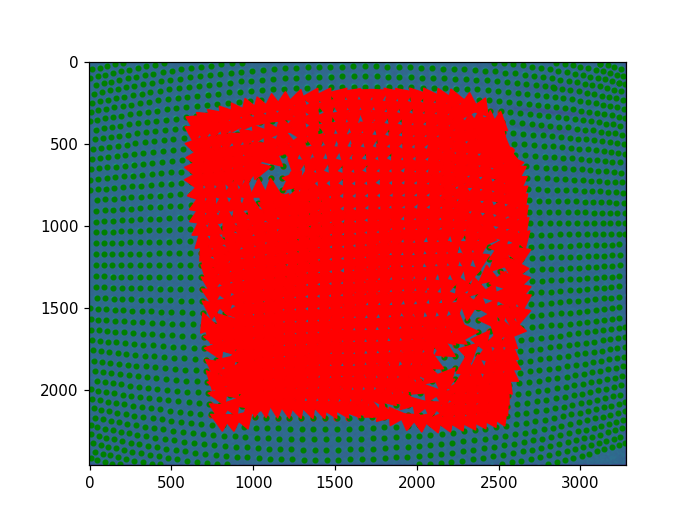

In [35]:
from scipy.spatial.distance import cdist
peaks_ref_xy = numpy.zeros_like(peaks_ref)
peaks_ref_xy[:,0] = peaks_ref[:,1]
peaks_ref_xy[:,1] = peaks_ref[:,0]
all_dist_12 = cdist(fitted_12, peaks_ref_xy,  'euclidean')
print(all_dist_12.shape)
dmin = all_dist_12.min(axis=1)
amin = all_dist_12.argmin(axis=1)
msk = dmin<40
print(msk.sum())
dataset_12 = numpy.zeros((msk.sum(), 4))
dataset_12[:,:2] = all_idx_12[msk]
dataset_12[:,2:] = peaks_ref_xy[amin[msk]]

# def unwrapd2(arg, data=dataset):
#     "convert indexes to distorted position"
#     u = rotate(arg[:8], data=data) 
#     c = numpy.atleast_2d(numpy.array((arg[0], arg[1])))
#     r1 =((u - c)**2).sum(axis=-1)
#     r2 = numpy.atleast_2d(r1).T
#     #for i in zip(dataset, r2, range(10)):
#     #    print(i[0], i[1])
#     K1 = arg[8]*1e-9
#     K2 = arg[9]*1e-12
#     return c + (u - c)*(1+K1*r2+K2*r2*r2)


# def errord2u(arg, data=dataset):
#     ex = unwrapd2(arg, data=data) 
#     di = data[:,2:]
#     d2 = (ex-di)**2
#     return numpy.sum(d2)


print(errord1u(list(res2d1u.x), data=dataset_12))
# fitted_12 = unwrapd1(list(res2d1u.x), data=dataset_12)
for i in zip(range(10), dataset_12, fitted_12):
        print(i[0], i[1], i[2])
f,ax = subplots()
ax.imshow(cnv, interpolation="nearest")
plot(fitted_12[:,0], fitted_12[:,1],".r")
plot(peaks_ref_xy[:,0],peaks_ref_xy[:, 1], ".g")
for ds, w in zip(dataset_12, fitted_12):
    ax.annotate("", xy=ds[2:], xytext=w,
                arrowprops=dict(facecolor='red', edgecolor='red'))





[[  705.6626624    329.34094632]
 [  701.08697831   393.63777222]
 [  697.00558765   459.32617336]
 ..., 
 [ 2559.601745    1975.52866958]
 [ 2554.8359077   2040.64683459]
 [ 2549.50788778  2104.40122451]]
10836.4121176
      fun: 7715.1176324416656
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 14.64459274,  -8.2567567 ,  -4.95410859,   0.08321877,
         0.91577022,   2.23635652,  23.18820407, -12.03989086,
        -1.85218596,  -4.1619387 ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2222
      nit: 164
   status: 0
  success: True
        x: array([  1.57016769e+03,   1.23141070e+03,   7.64365933e+01,
         1.54461960e+00,  -1.54097141e+00,   7.66397514e+01,
        -8.91205896e-01,   9.74719387e-02,  -5.28875166e+01,
         3.87569314e-03])


<IPython.core.display.Javascript object>


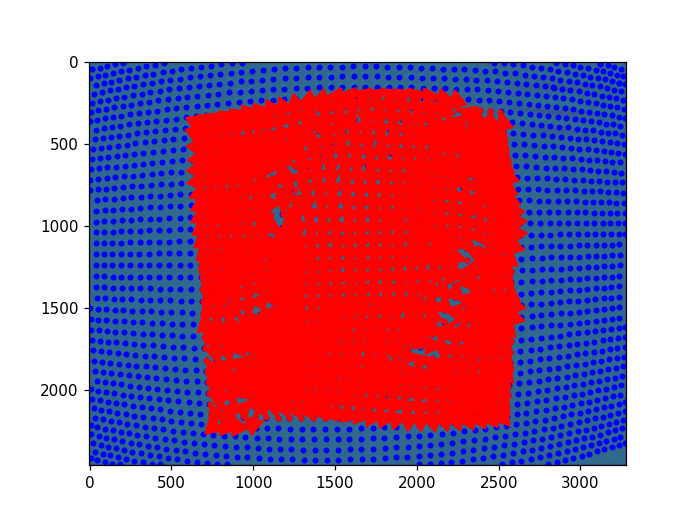

In [36]:
def unwrapd2(arg, data=dataset):
    "convert indexes to distorted position"
    u = rotate(arg[:8], data=data) 
    c = numpy.atleast_2d(numpy.array((arg[0], arg[1])))
    r1 =((u - c)**2).sum(axis=-1)
    r2 = numpy.atleast_2d(r1).T
    #for i in zip(dataset, r2, range(10)):
    #    print(i[0], i[1])
    K1 = arg[8]*1e-9
    K2 = arg[9]*1e-12
    return c + (u - c)*(1+K1*r2+K2*r2*r2)


def errord2u(arg, data=dataset):
    ex = unwrapd2(arg, data=data) 
    di = data[:,2:]
    d2 = (ex-di)**2
    return numpy.sum(d2)

bounds2d2=bounds2d1 + [(None,None)]

print(unwrapd2(list(res2d1u.x)+[0], dataset_12))
print(errord2u(list(res2d1u.x)+[0], dataset_12))
res12d2u  = minimize(errord2u, list(res2d1u.x)+[0], bounds=bounds2d2, args=(dataset_12,))
print(res12d2u)
fitted_12r =  unwrapd2(res12d2u.x, data=dataset_12)
f,ax = subplots()
ax.imshow(cnv, interpolation="nearest")
plot(peaks_ref_xy[:,0],peaks_ref_xy[:, 1], ".b")
plot(fitted_12[:,0], fitted_12[:,1],".r")
for ds, w in zip(dataset_12, fitted_12r):
    ax.annotate("", xy=ds[2:], xytext=w,
                arrowprops=dict(facecolor='red', edgecolor='red'))

ErrorMetric(mean=3.5037291930522874, median=2.9151807503992857, min=0.042473509031056705, max=14.502560276239137, std=2.2219502336171542, count=961, sqsum=16541.867036060346)
      fun: 15308.462419190311
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([  9.46565706e+00,   2.38236680e+01,  -4.95310815e-01,
         2.54058250e+00,  -2.63753464e-02,  -1.29148248e-02,
        -1.83690645e+01,  -7.78636604e+00,   1.96892870e+01,
        -2.58782165e+01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2222
      nit: 165
   status: 0
  success: True
        x: array([  1.56960986e+03,   1.23032763e+03,   7.63837128e+01,
         1.53344350e+00,  -1.54498363e+00,   7.65827244e+01,
        -9.05384350e-01,   9.45636857e-02,  -5.13218348e+01,
         3.04337914e-03])
ErrorMetric(mean=3.5613078197533028, median=3.3278064225145969, min=0.15790063713001756, max=11.903739544656576, std=1.8018901667403366, count=961, sqsum=15308.462419190311)


<IPython.core.display.Javascript object>


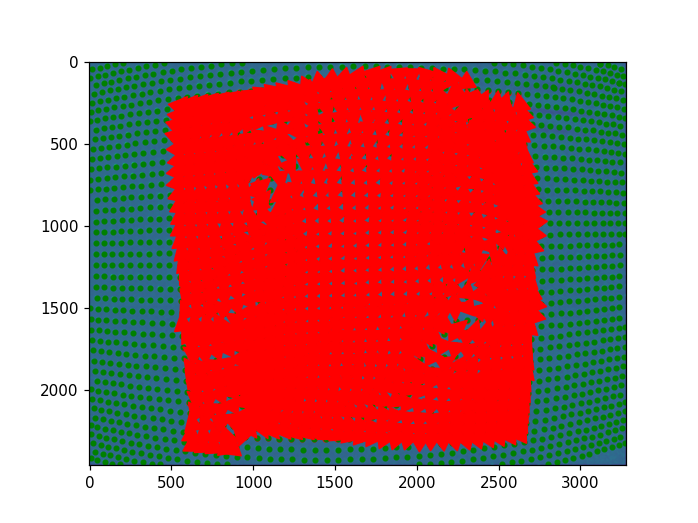

In [37]:
from collections import namedtuple
ErrorMetric = namedtuple("ErrorMetric",["mean", "median", "min", "max", "std", "count", "sqsum"])
bounds2d2 = [(1500,1800),(1000, 1500), (60,100), (-5, 5), (-5, 5), (60,100), 
             (-10, 10),(-10, 10), (None, None), (None, None)]
def extract_points(size=10, precision=40, unwrapf=unwrapd2, param=res12d2u.x):
    all_idx = numpy.array(list(itertools.product(range(-size, size+1),range(-size, size+1)))).astype("float64")
    expected = unwrapf(param, data=all_idx)
    all_dist = cdist(expected, peaks_ref_xy,  'euclidean')
    amin = all_dist.argmin(axis=1)
    dmin = all_dist.min(axis=1)
    msk = dmin < precision
    dataset = numpy.zeros((msk.sum(), 4))
    dataset[:,:2] = all_idx[msk]
    dataset[:,2:] = peaks_ref_xy[amin[msk]]
    return dataset

def mean_error(unwrapf, param, dataset):
    ex = unwrapf(param, data=dataset) 
    di = dataset[:,2:]
    d2 = (ex-di)**2
    dist = numpy.sqrt(numpy.sum(d2, axis=-1))
    res = ErrorMetric(dist.mean(), numpy.median(dist), dist.min(), dist.max(), dist.std(), len(dist), (dist*dist).sum())
    return res

def display_error(unwrapf, param, dataset):
    fitted =  unwrapf(param, data=dataset)
    f,ax = subplots()
    ax.imshow(cnv, interpolation="nearest")
    plot(fitted[:,0], fitted[:,1],".r")
    plot(peaks_ref_xy[:,0],peaks_ref_xy[:, 1], ".g")
    for ds, w in zip(dataset, fitted):
        ax.annotate("", xy=ds[2:], xytext=w,
                    arrowprops=dict(facecolor='red', edgecolor='red'))

dataset_15 = extract_points(15, 40, unwrapd2, res12d2u.x)

print(mean_error(unwrapd2, res12d2u.x, dataset_15))

res15d2u  = minimize(errord2u, res12d2u.x, bounds=bounds2d2, args=(dataset_15,))
print(res15d2u)
print(mean_error(unwrapd2, res15d2u.x, dataset_15))

display_error(unwrapd2, res15d2u.x, dataset_15)


ErrorMetric(mean=4.1894423275858825, median=3.6302768250696178, min=0.12615834716130081, max=16.023460770053973, std=2.5359912072703965, count=1225, sqsum=29378.781063913193)
      fun: 28017.490477442152
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([   4.77884896,   70.15041774,   14.30380507,   -4.45725163,
         31.86760296,    1.97687768,  -10.14923328,   22.67915988,
        -36.08147381,  273.94889912])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 682
      nit: 44
   status: 0
  success: True
        x: array([  1.56960983e+03,   1.23032567e+03,   7.63927980e+01,
         1.52513713e+00,  -1.54959711e+00,   7.66043394e+01,
        -9.12997551e-01,   1.07442194e-01,  -5.13188431e+01,
         2.97475864e-03])
ErrorMetric(mean=4.254132851141943, median=3.9910481096545278, min=0.20289440180271881, max=14.820042153832732, std=2.1848969043748698, count=1225, sqsum=28017.490477442152)
Second pass
ErrorMetric(mean=4.2541328511

<IPython.core.display.Javascript object>


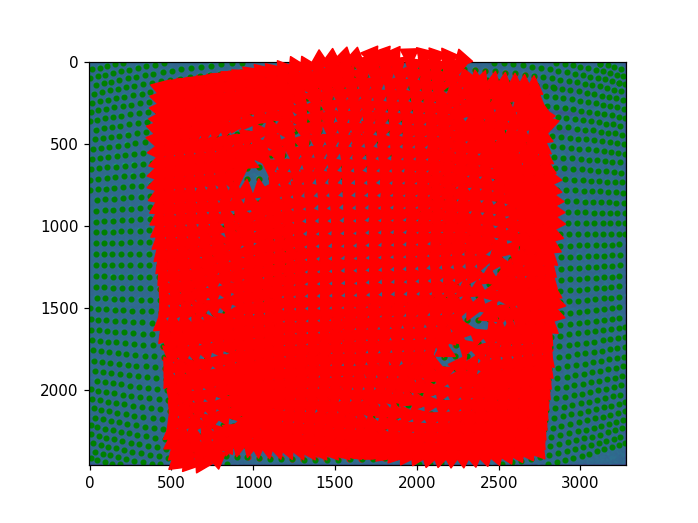

In [38]:
dataset_17 = extract_points(17, 40, unwrapd2, res15d2u.x)

print(mean_error(unwrapd2, res15d2u.x, dataset_17))
res17d2u  = minimize(errord2u, res15d2u.x, bounds=bounds2d2, args=(dataset_17,))
print(res17d2u)
print(mean_error(unwrapd2, res17d2u.x, dataset_17))

print("Second pass")
dataset_17b = extract_points(17, 40, unwrapd2, res17d2u.x)

print(mean_error(unwrapd2, res17d2u.x, dataset_17b))
res17d2ub  = minimize(errord2u, res17d2u.x, bounds=bounds2d2, args=(dataset_17b,))
print(res17d2ub)
print(mean_error(unwrapd2, res17d2ub.x, dataset_17b))
display_error(unwrapd2, res17d2ub.x, dataset_17b)

ErrorMetric(mean=5.2108202643571673, median=4.4020114394540872, min=0.20289389236155284, max=24.912630204175898, std=3.3648920036922987, count=1496, sqsum=57558.818451825719)
      fun: 52680.200685144402
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -55.73019735,  257.07122404,   72.73847586,  -88.22971722,
        118.0000254 ,  155.51777324,   -3.56594683,    3.78349796,
       -576.65238273,    7.0031092 ])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 495
      nit: 33
   status: 0
  success: True
        x: array([  1.56961057e+03,   1.23032208e+03,   7.64551904e+01,
         1.52629641e+00,  -1.54856415e+00,   7.66424723e+01,
        -9.19569801e-01,   1.28200129e-01,  -5.13021288e+01,
         2.81711048e-03])
ErrorMetric(mean=5.2226630193054397, median=4.8550437289400037, min=0.1416067816371685, max=19.544403776227949, std=2.8174152831839852, count=1496, sqsum=52680.200685144395)


<IPython.core.display.Javascript object>


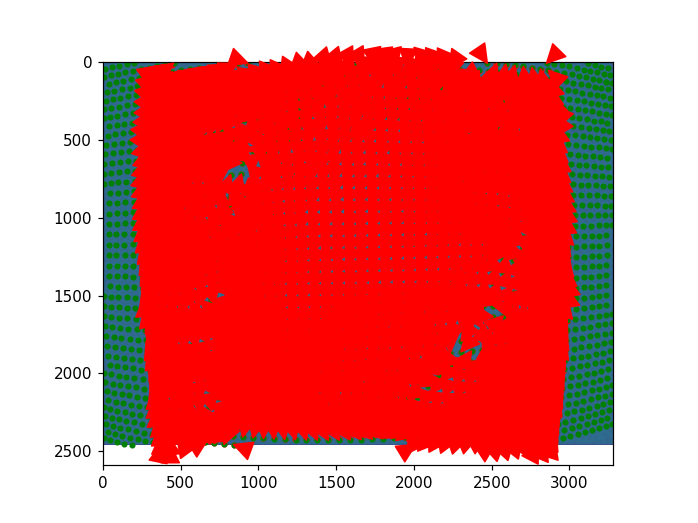

In [39]:
dataset_20 = extract_points(20, 38, unwrapd2, res17d2ub.x)

print(mean_error(unwrapd2, res17d2ub.x, dataset_20))
res20d2u  = minimize(errord2u, res17d2ub.x, bounds=bounds2d2, args=(dataset_20,))
print(res20d2u)
print(mean_error(unwrapd2, res20d2u.x, dataset_20))

#print("second pass")
#dataset_20b = extract_points(20, 30, unwrapd2, res20d2u.x)

# print(mean_error(unwrapd2, res20d2u.x, dataset_20b))
# res20d2ub  = minimize(errord2u, res20d2u.x, bounds=bounds2d2, args=(dataset_20b,))
# print(res20d2ub)
# print(mean_error(unwrapd2, res20d2ub.x, dataset_20b))

# print("third pass")
# dataset_20c = extract_points(20, 30, unwrapd2, res20d2ub.x)

# print(mean_error(unwrapd2, res20d2ub.x, dataset_20c))
# res20d2uc  = minimize(errord2u, res20d2ub.x, bounds=bounds2d2, args=(dataset_20c,))
# print(res20d2uc)
# print(mean_error(unwrapd2, res20d2uc.x, dataset_20c))


# print("Fourth pass")
# dataset_20d = extract_points(20, 30, unwrapd2, res20d2uc.x)

# print(mean_error(unwrapd2, res20d2uc.x, dataset_20d))
# res20d2ud  = minimize(errord2u, res20d2uc.x, bounds=bounds2d2, args=(dataset_20d,))
# print(res20d2ud)
# print(mean_error(unwrapd2, res20d2ud.x, dataset_20d))

display_error(unwrapd2, res20d2u.x, dataset_20)

21: first pass
ErrorMetric(mean=5.4667932405544946, median=4.9960214106062804, min=0.1416067816371685, max=21.286812947053171, std=3.0725853848787077, count=1575, sqsum=61939.409619689526)
      fun: 61541.073869919855
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([  -82.35583664,   327.55488064,   583.76317611,   199.07020032,
        -451.98685257,   281.21285141,   -12.66016625,    12.21924322,
        -769.80359154, -1890.15554497])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 616
      nit: 44
   status: 0
  success: True
        x: array([  1.56961172e+03,   1.23031734e+03,   7.64728234e+01,
         1.52695610e+00,  -1.54633126e+00,   7.66560895e+01,
        -9.20950844e-01,   1.34571981e-01,  -5.12869726e+01,
         2.78248020e-03])
ErrorMetric(mean=5.4980864873581101, median=5.148337472354533, min=0.0040001344900288767, max=20.140363880465664, std=2.974011209245413, count=1575, sqsum=61541.073869919863)


<IPython.core.display.Javascript object>


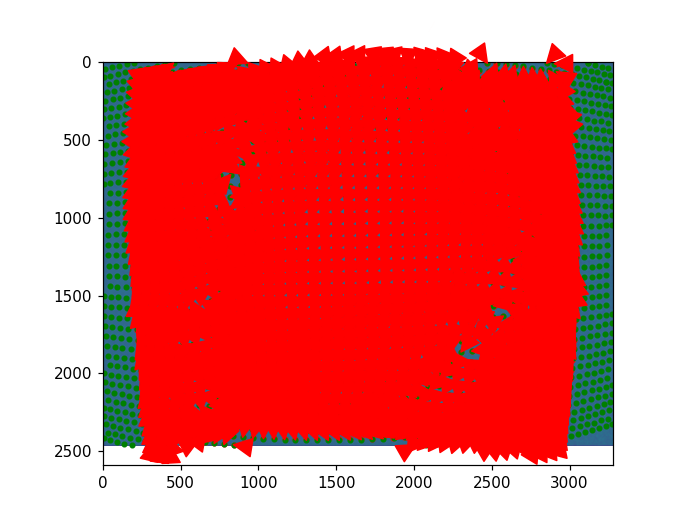

In [40]:
print("21: first pass")
dataset_21 = extract_points(21, 38, unwrapd2, res20d2u.x)

print(mean_error(unwrapd2, res20d2u.x, dataset_21))
res21d2u  = minimize(errord2u, res20d2u.x, bounds=bounds2d2, args=(dataset_21,))
print(res21d2u)
print(mean_error(unwrapd2, res21d2u.x, dataset_21))

# print("21: second pass")
# dataset_21b = extract_points(21, 30, unwrapd2, res21d2u.x)
# print(mean_error(unwrapd2, res21d2u.x, dataset_21b))
# res21d2ub  = minimize(errord2u, res21d2u.x, bounds=bounds2d2, args=(dataset_21b,))
# print(res21d2ub)
# print(mean_error(unwrapd2, res21d2ub.x, dataset_21b))

display_error(unwrapd2, res21d2u.x, dataset_21)


22: first pass
ErrorMetric(mean=5.7665085095261865, median=5.3365670172196351, min=0.0040001344900288767, max=30.532262222648217, std=3.2895207698596067, count=1655, sqsum=72941.753857958713)
      fun: 61541.073869919855
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([  -82.35583664,   327.55488064,   583.76317611,   199.07020032,
        -451.98685257,   281.21285141,   -12.66016625,    12.21924322,
        -769.80359154, -1890.15554497])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 616
      nit: 44
   status: 0
  success: True
        x: array([  1.56961172e+03,   1.23031734e+03,   7.64728234e+01,
         1.52695610e+00,  -1.54633126e+00,   7.66560895e+01,
        -9.20950844e-01,   1.34571981e-01,  -5.12869726e+01,
         2.78248020e-03])
ErrorMetric(mean=5.7665085095261865, median=5.3365670172196351, min=0.0040001344900288767, max=30.532262222648217, std=3.2895207698596067, count=1655, sqsum=72941.753857958713)


/usr/lib/python2.7/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


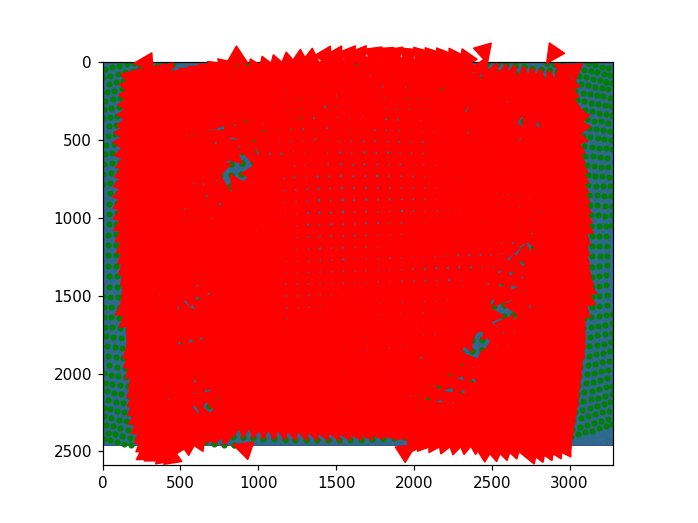

In [41]:
print("22: first pass")
dataset_22 = extract_points(22, 38, unwrapd2, res21d2u.x)

print(mean_error(unwrapd2, res21d2u.x, dataset_22))
res22d2u  = minimize(errord2u, res21d2u.x, bounds=bounds2d2, args=(dataset_22,))
print(res21d2u)
print(mean_error(unwrapd2, res21d2u.x, dataset_22))

# print("22: second pass")
# dataset_22b = extract_points(22, 30, unwrapd2, res22d2u.x)
# print(mean_error(unwrapd2, res22d2u.x, dataset_22b))
# res22d2ub  = minimize(errord2u, res22d2u.x, bounds=bounds2d2, args=(dataset_22b,))
# print(res22d2ub)
# print(mean_error(unwrapd2, res22d2ub.x, dataset_22b))

display_error(unwrapd2, res22d2u.x, dataset_22)



Extract 22 shells
ErrorMetric(mean=5.7617543222258654, median=5.4774806750352587, min=0.2553113425143882, max=33.898767617906678, std=3.1331536385763537, count=1655, sqsum=71188.938900773996)
      fun: 71188.938847386831
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-109.49734133,  387.61063479,  -12.72128429,    4.89817467,
          4.35102265,  -25.66230251,   94.36043911,   64.16812539,
        156.71830624,   23.21030479])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 33
      nit: 1
   status: 0
  success: True
        x: array([  1.56980753e+03,   1.22948783e+03,   7.62619374e+01,
         1.52743117e+00,  -1.53638219e+00,   7.64528772e+01,
        -9.18960925e-01,   1.28862628e-01,  -4.91342150e+01,
         2.32191144e-03])
ErrorMetric(mean=5.7617526094863907, median=5.4775006966771125, min=0.25534294851339789, max=33.898363176751793, std=3.1331567830913514, count=1655, sqsum=71188.938847386831)


<IPython.core.display.Javascript object>


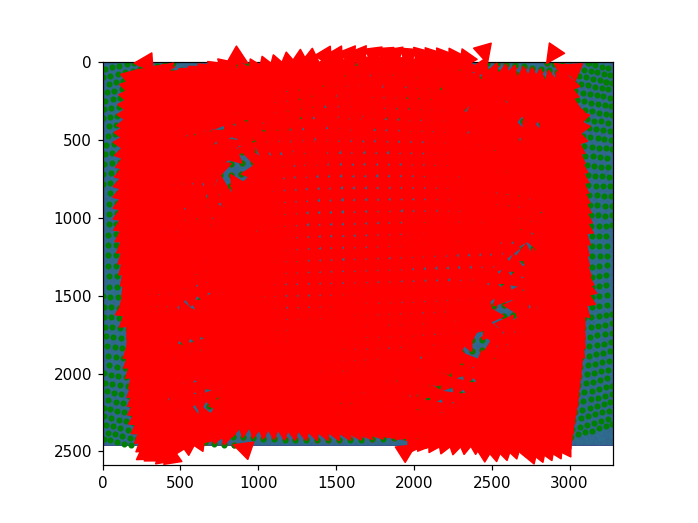

Extract 22 shells
ErrorMetric(mean=5.7617526094863907, median=5.4775006966771125, min=0.25534294851339789, max=33.898363176751793, std=3.1331567830913514, count=1655, sqsum=71188.938847386831)
      fun: 71188.93884314099
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.09538087e+02,   3.87609180e+02,  -1.52082066e+01,
         4.76720743e+00,   4.31027729e+00,  -2.71058525e+01,
         9.61794285e+01,   6.43645762e+01,   1.55199086e+02,
        -5.47188683e+03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 33
      nit: 1
   status: 0
  success: True
        x: array([  1.56980753e+03,   1.22948783e+03,   7.62619374e+01,
         1.52743116e+00,  -1.53638219e+00,   7.64528772e+01,
        -9.18960930e-01,   1.28862623e-01,  -4.91342151e+01,
         2.32190003e-03])
ErrorMetric(mean=5.7617544569002863, median=5.4774789329813567, min=0.25530960692293109, max=33.898794635922926, std=3.1331533853577618, count=1655, sqsum=71188.93

<IPython.core.display.Javascript object>


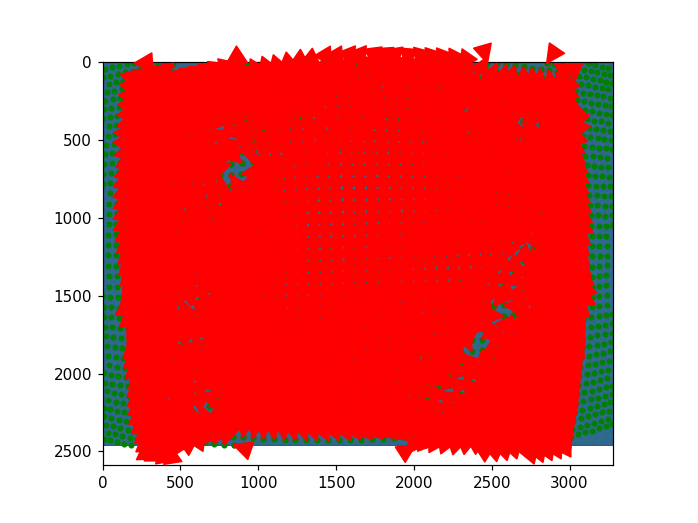

Extract 22 shells
ErrorMetric(mean=5.7617544569002863, median=5.4774789329813567, min=0.25530960692293109, max=33.898794635922926, std=3.1331533853577618, count=1655, sqsum=71188.93884314099)
      fun: 71188.938784307044
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-109.49734133,  387.61063479,  -12.72128429,    4.89526428,
          4.3597538 ,  -25.65502655,   94.29932106,   64.12155926,
        156.71685105,   21.65033948])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 33
      nit: 1
   status: 0
  success: True
        x: array([  1.56980753e+03,   1.22948783e+03,   7.62619374e+01,
         1.52743116e+00,  -1.53638219e+00,   7.64528772e+01,
        -9.18960930e-01,   1.28862623e-01,  -4.91342151e+01,
         2.32191145e-03])
ErrorMetric(mean=5.7617526314158551, median=5.4775002718778412, min=0.2553432919411967, max=33.898363588037654, std=3.1331567366814523, count=1655, sqsum=71188.938784307029)


<IPython.core.display.Javascript object>


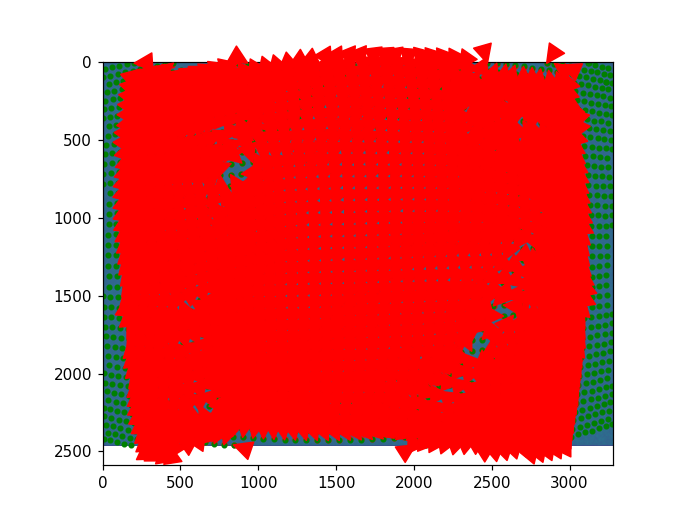

In [42]:
def fit_range(size, precision, function, old_param):
    def error(param, dataset):
        ex = function(param, dataset) 
        di = dataset[:,2:]
        delta2 = (ex-di)**2
        return delta2.sum()

    print("Extract %i shells"%size)
    dataset = extract_points(size, precision, function, old_param)
    print(mean_error(function, old_param, dataset))
    bounds = bounds2d2 + [(None, None)]*(len(old_param)-len(bounds2d2))
    fitted = minimize(error, old_param, bounds=bounds, args=(dataset,))
    print(fitted)
    print(mean_error(function, fitted.x, dataset))
    display_error(function, fitted.x, dataset)
    return fitted.x

fit_22a = fit_range(22, 35, unwrapd2, numpy.array(res22d2u.x))
fit_22b = fit_range(22, 35, unwrapd2, fit_22a)
fit_22c = fit_range(22, 35, unwrapd2, fit_22b)
#fit_22a = fit_range(22, 30, unwrapd2, res21d2ub.x)

Extract 22 shells
ErrorMetric(mean=5.7617543222258645, median=5.4774806750352587, min=0.2553113425143882, max=33.898767617906678, std=3.1331536385763523, count=1655, sqsum=71188.938900773981)
      fun: 69047.180797557652
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -2.57568900e-01,  -1.01863407e-02,   1.36351446e+00,
         4.49799700e+00,   2.05909600e+00,  -3.36294761e+00,
         1.74783054e+01,  -1.35463779e+01,  -8.09086487e-01,
        -2.96568032e+00,  -1.44063961e-01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 4932
      nit: 368
   status: 0
  success: True
        x: array([  1.57180836e+03,   1.21967962e+03,   7.63637846e+01,
         1.53417372e+00,  -1.53284647e+00,   7.65566583e+01,
        -8.85895935e-01,  -1.51538527e-02,  -5.09132358e+01,
         3.10315805e+00,  -9.47232101e+00])
ErrorMetric(mean=5.722769848414055, median=5.3936642093249896, min=0.25280724823866879, max=33.654233805808389, std=2.99503

<IPython.core.display.Javascript object>


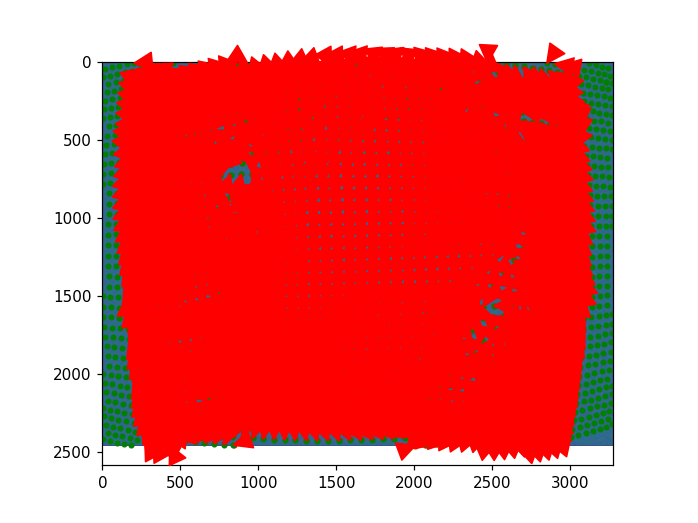

Extract 22 shells
ErrorMetric(mean=5.722769848414055, median=5.3936642093249896, min=0.25280724823866879, max=33.654233805808389, std=2.9950385969404683, count=1655, sqsum=69047.180797557652)
      fun: 69047.180775937188
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0174623 , -0.29394869,  1.47847459,  4.40923031,  1.75350579,
       -3.27709131,  1.16851879,  5.35801519, -0.72759576, -2.63680704,
       -0.13969839])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 1
   status: 0
  success: True
        x: array([  1.57180836e+03,   1.21967962e+03,   7.63637845e+01,
         1.53417316e+00,  -1.53284673e+00,   7.65566587e+01,
        -8.85897078e-01,  -1.51525963e-02,  -5.09132357e+01,
         3.10315843e+00,  -9.47232099e+00])
ErrorMetric(mean=5.7227855812273818, median=5.3937853273361016, min=0.25290073801719604, max=33.654308027169009, std=2.9950085330950902, count=1655, sqsum=69047.180775937188)


<IPython.core.display.Javascript object>


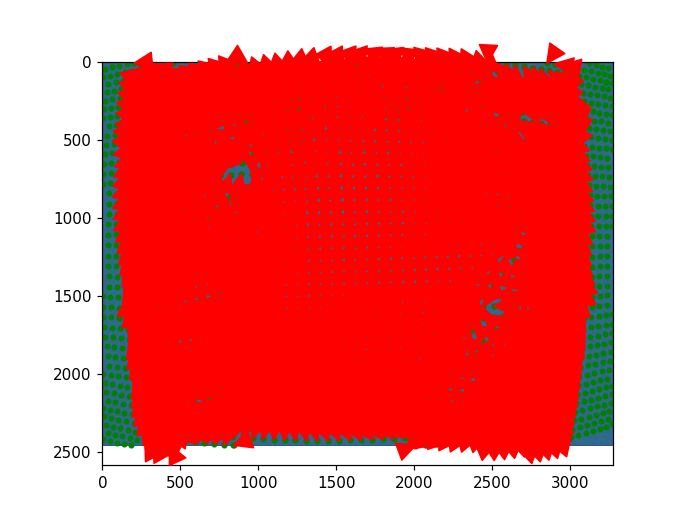

Extract 22 shells
ErrorMetric(mean=5.7227855812273818, median=5.3937853273361016, min=0.25290073801719604, max=33.654308027169009, std=2.9950085330950902, count=1655, sqsum=69047.180775937188)
      fun: 69047.180770250547
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.02764864, -0.10768417,  1.49011612,  4.24188329,  1.82481017,
       -3.06026777, -1.38534233, -7.22502591, -0.62427716, -2.34867912,
       -0.13242243])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 1
   status: 0
  success: True
        x: array([  1.57180836e+03,   1.21967962e+03,   7.63637842e+01,
         1.53417246e+00,  -1.53284700e+00,   7.65566592e+01,
        -8.85897261e-01,  -1.51534354e-02,  -5.09132356e+01,
         3.10315884e+00,  -9.47232097e+00])
ErrorMetric(mean=5.7227829028470989, median=5.3937317353174725, min=0.25291154474807614, max=33.654303032176912, std=2.9950136502963258, count=1655, sqsum=69047.180770250561)


<IPython.core.display.Javascript object>


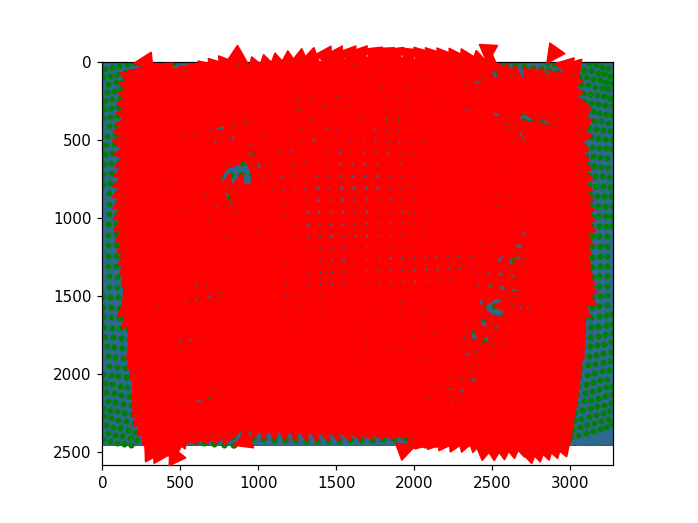

In [43]:
def unwrapd3(arg, data=dataset):
    "convert indexes to distorted position"
    u = rotate(arg[:8], data=data) 
    c = numpy.atleast_2d(numpy.array((arg[0], arg[1])))
    r1 =((u - c)**2).sum(axis=-1)
    r2 = numpy.atleast_2d(r1).T
    #for i in zip(dataset, r2, range(10)):
    #    print(i[0], i[1])
    K1 = arg[8]*1e-9
    K2 = arg[9]*1e-15
    K3 = arg[10]*1e-23
    return c + (u - c)*(1.0 + K1*r2 + K2*r2*r2 + K3*r2*r2*r2)
fit_22a = fit_range(22, 35, unwrapd3, list(res22d2u.x)[:-1]+[res22d2u.x[-1]*1e3, 0.0])
fit_22b = fit_range(22, 35, unwrapd3, fit_22a)
fit_22c = fit_range(22, 35, unwrapd3, fit_22b)
#fit_22c = fit_range(22, 35, unwrapd3, fit_22b)


Extract 23 shells
ErrorMetric(mean=5.9545456724616406, median=5.5208875596528664, min=0.25291154474807614, max=33.654303032176912, std=3.2224483123344565, count=1735, sqsum=79533.765950056462)
      fun: 79137.762906853721
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 12.22069841,   6.97036739,  12.55830284, -11.72884367,
         0.03055902,  -7.00092642,  15.18637873,   2.58587534,
         2.96422513,   5.02041075,   5.20230969])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 888
      nit: 65
   status: 0
  success: True
        x: array([  1.57253153e+03,   1.21850090e+03,   7.63495121e+01,
         1.53435111e+00,  -1.52720658e+00,   7.65462812e+01,
        -8.75902832e-01,  -2.61337689e-02,  -5.07484033e+01,
         3.06702888e+00,  -9.63680944e+00])
ErrorMetric(mean=5.9945919202514162, median=5.6722983199972106, min=0.03184778510881478, max=34.392888202005444, std=3.1108537689547475, count=1735, sqsum=79137.762906853721)


<IPython.core.display.Javascript object>


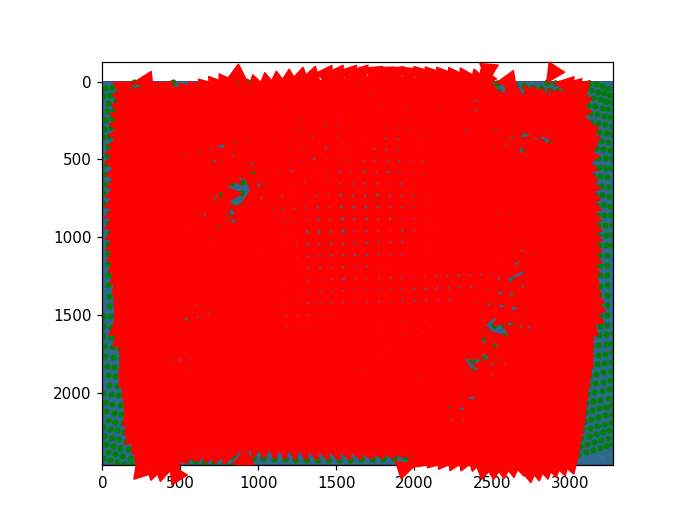

Extract 23 shells
ErrorMetric(mean=5.9945919202514162, median=5.6722983199972106, min=0.03184778510881478, max=34.392888202005444, std=3.1108537689547475, count=1735, sqsum=79137.762906853721)
      fun: 79137.762750567781
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 13.15638656,   7.22357072,   9.7163138 , -11.260272  ,
         0.09458745,  -6.28642738, -46.29837349, -15.88050509,
         2.26718839,   2.70520104,   5.12372935])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 1
   status: 0
  success: True
        x: array([  1.57253152e+03,   1.21850090e+03,   7.63495061e+01,
         1.53435278e+00,  -1.52720659e+00,   7.65462845e+01,
        -8.75907224e-01,  -2.61350138e-02,  -5.07484047e+01,
         3.06702646e+00,  -9.63681194e+00])
ErrorMetric(mean=5.9946215997296335, median=5.6721521094969178, min=0.031510618343793741, max=34.39327165714171, std=3.1107965616767825, count=1735, sqsum=79137.762750567766)


<IPython.core.display.Javascript object>


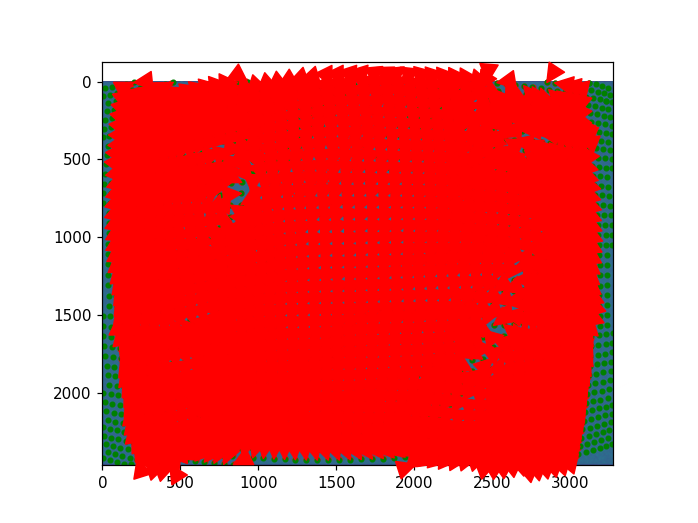

In [44]:
fit_23a = fit_range(23, 38, unwrapd3, fit_22c)
fit_23b = fit_range(23, 38, unwrapd3, fit_23a)


Extract 24 shells
ErrorMetric(mean=6.2167134409611853, median=5.8189610143345591, min=0.031510618343793741, max=21.145762145305003, std=3.2792459663803317, count=1815, sqsum=89662.778908814187)
      fun: 89184.669190006432
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -3.83734005,  -3.5885023 , -10.37114998, -10.43517841,
         5.29835233,   1.23254722,  27.64718374, -38.22060535,
         1.34605216,   5.55155566,  10.01899363])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1812
      nit: 138
   status: 0
  success: True
        x: array([  1.57303864e+03,   1.21695842e+03,   7.63372137e+01,
         1.53203665e+00,  -1.52024616e+00,   7.65388971e+01,
        -8.69209943e-01,  -4.24329442e-02,  -5.06410001e+01,
         3.05979880e+00,  -1.01350965e+01])
ErrorMetric(mean=6.261681906591404, median=5.9814531083270204, min=0.22965610727217145, max=20.325641931378989, std=3.1510154685495508, count=1815, sqsum=89184.669190006447

<IPython.core.display.Javascript object>


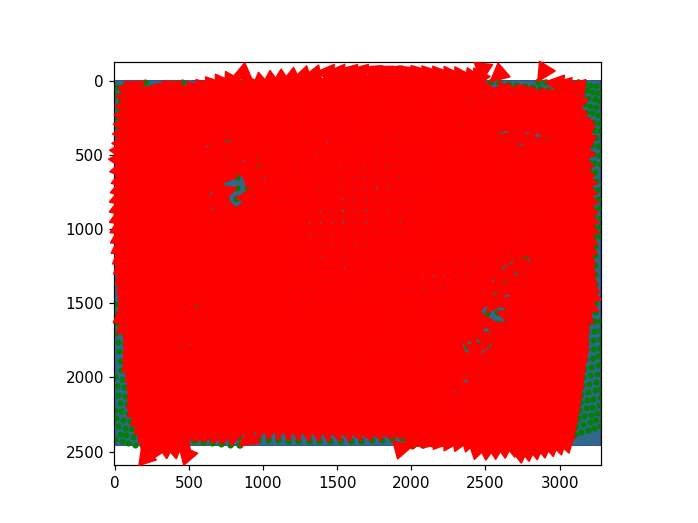

Extract 25 shells
ErrorMetric(mean=6.4652157918480011, median=6.095638674227474, min=0.22965610727217145, max=21.810596943057952, std=3.3701497385930477, count=1886, sqsum=100253.95959888934)
      fun: 99932.965259885794
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -0.93714334,  -1.39407348,   1.94413587,  18.48384272,
         6.1962055 , -11.04199328,  11.06527634,  -5.29980753,
        -2.38360371, -15.12817107,   5.48607204])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1332
      nit: 102
   status: 0
  success: True
        x: array([  1.57351903e+03,   1.21559427e+03,   7.63383410e+01,
         1.53222601e+00,  -1.52260735e+00,   7.65419409e+01,
        -8.62631826e-01,  -5.72452536e-02,  -5.06747731e+01,
         3.07675566e+00,  -1.04013545e+01])
ErrorMetric(mean=6.5034690519727612, median=6.2270495692746284, min=0.27927531892551521, max=21.403672242706207, std=3.2698037101173658, count=1886, sqsum=99932.965259885794)

<IPython.core.display.Javascript object>


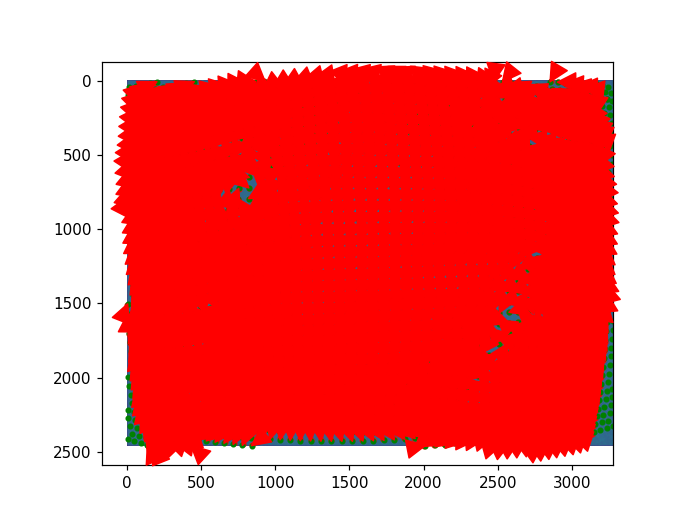

Extract 26 shells
ErrorMetric(mean=6.6516591053654457, median=6.2956224064250623, min=0.27927531892551521, max=22.288765409037335, std=3.4534759404632109, count=1935, sqsum=108691.01063055091)
      fun: 108508.77769949738
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -2.3341272 ,  -3.20724212,   9.48493835,  -1.35914888,
         3.4851837 ,   3.41970008,  35.34078132,  38.27590263,
         2.99769454,  -1.34459697,   6.20784704])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1416
      nit: 103
   status: 0
  success: True
        x: array([  1.57385806e+03,   1.21464330e+03,   7.63385890e+01,
         1.53513816e+00,  -1.53098028e+00,   7.65429026e+01,
        -8.57946862e-01,  -6.79020618e-02,  -5.06962769e+01,
         3.09227589e+00,  -1.06917644e+01])
ErrorMetric(mean=6.6759971213082041, median=6.3627367754371269, min=0.35705796821650287, max=22.160912192261915, std=3.3923369726905399, count=1935, sqsum=108508.77769949738

<IPython.core.display.Javascript object>


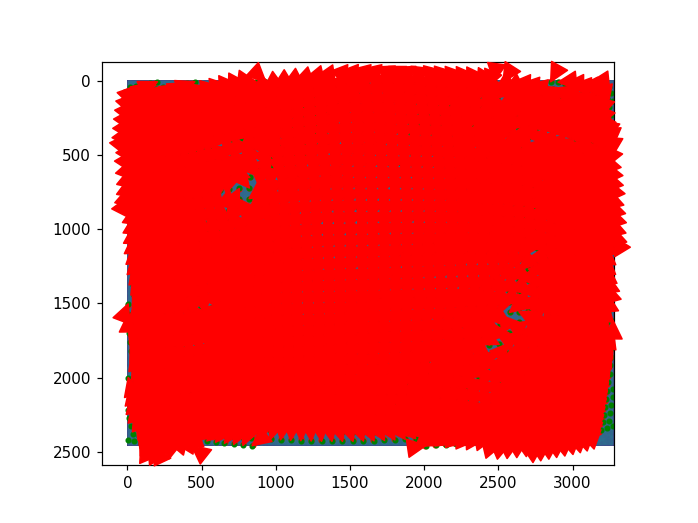

Extract 27 shells
ErrorMetric(mean=6.7415272657607517, median=6.4031271638139735, min=0.35705796821650287, max=23.173315525724945, std=3.4787749577890108, count=1959, sqsum=112740.57749551178)
      fun: 112700.40002875033
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
      jac: array([-18.27138476,  20.5473043 ,  -8.46630428,   0.12514647,
       -10.70729923,  -5.90225682,   6.04777597, -53.25127859,
        12.50591595, -11.83070708,   4.40777512])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 420
      nit: 27
   status: 0
  success: True
        x: array([  1.57387261e+03,   1.21462725e+03,   7.63353938e+01,
         1.54051295e+00,  -1.53521204e+00,   7.65379120e+01,
        -8.57966571e-01,  -6.67364785e-02,  -5.06541007e+01,
         3.08345629e+00,  -1.07113223e+01])
ErrorMetric(mean=6.7466490487861908, median=6.4335960467064099, min=0.3988265838225627, max=23.20938460560706, std=3.465873991225541, count=1959, sqsum=112700.40002875034)


<IPython.core.display.Javascript object>


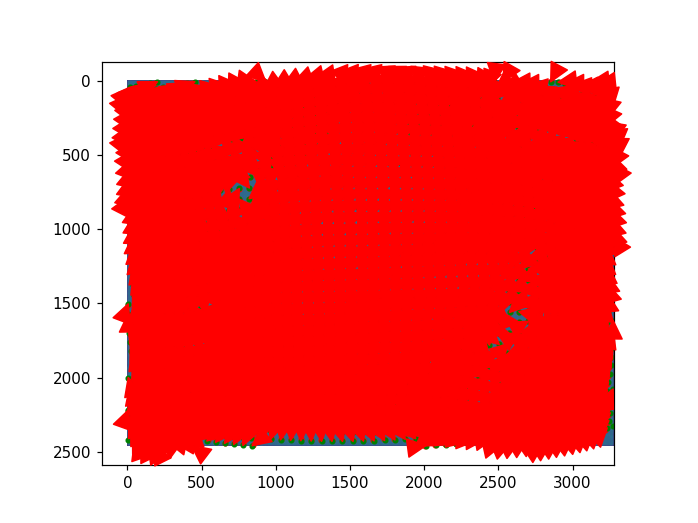

In [45]:
fit_24a = fit_range(24, 30, unwrapd3, fit_23b)
fit_25a = fit_range(25, 30, unwrapd3, fit_24a)
fit_26a = fit_range(26, 30, unwrapd3, fit_25a)
fit_27a = fit_range(27, 30, unwrapd3, fit_26a)


In [46]:
def correct2(coord, arg=fit_24a):
    "convert position to distorted position"
    c0, c1 = arg[:2]
    u0, u1 = coord
    r2 =(c0 - u0)**2 + (c1 - u1)**2
    K1 = arg[8]*1e-9
    K2 = arg[9]*1e-15
    cor = (1.0+K1*r2+K2*r2*r2)
    return (c0 + (u0 - c0)*cor, c1 + (u1 - c1)*cor)

def correct3(coord, arg=fit_24a):
    "convert indexes to distorted position"
    center = numpy.atleast_2d(arg[:2])
    delta = coord - center
    dist2 = (dist**2).sum(axis=-1)
    K1 = arg[8]*1e-9
    K2 = arg[9]*1e-15
    K3 = arg[10]*1e-23
    correction = (1.0 + K1*dist2 + K2*dist2*dist2 + K3*dist2*dist2*dist2)
    return (center+delta/(numpy.atleast_2d(correction).T))


In [47]:
print(fit_24a)
corners = numpy.array([[0.0,0.0],[3280.0,0.0],[3280.0,2464.0],[0.0, 2464.0]])
#print(correct3(corners))
center = numpy.atleast_2d([1.49120525e+03,   1.05505442e+03 ])
coord = numpy.atleast_2d(corners)
delta = coord - center
dist2 = (delta**2).sum(axis=-1)
print(dist2)
K1 = fit_24a[8]*1e-9
K2 = fit_24a[9]*1e-15
K3 = fit_24a[10]*1e-23
correction = (1.0 + K1*dist2 + K2*dist2*dist2 + K3*dist2*dist2*dist2)
print(correction)
limits = (center+delta/(numpy.atleast_2d(correction).T))
print(limits)
limits.max(axis=0)-limits.min(axis=0)

[  1.57303864e+03   1.21695842e+03   7.63372137e+01   1.53203665e+00
  -1.52024616e+00   7.65388971e+01  -8.69209943e-01  -4.24329442e-02
  -5.06410001e+01   3.05979880e+00  -1.01350965e+01]
[ 3336832.9267891  4312926.4867891  5184914.3050291  4208820.7450291]
[ 0.86132306  0.83037443  0.80556127  0.83350661]
[[ -240.09084964  -169.86857585]
 [ 3645.40784354  -215.52230094]
 [ 3711.76229957  2804.07791201]
 [ -297.86904236  2745.4376295 ]]


array([ 4009.63134194,  3019.60021295])

In [48]:
1024*1.5

1536.0

In [49]:
from collections import OrderedDict
res = OrderedDict()
res["center_x"] = fit_27a[0]
res["center_y"] = fit_27a[1]
res["K1"] = fit_27a[8]*1e-9
res["K2"] = fit_27a[9]*1e-15
res["K3"] = fit_27a[10]*1e-23
import json
with open("RPI_cam_v2_lense_2.8mm.json", "w") as f:
    f.write(json.dumps(res, indent=4))


In [50]:
import os
os.environ

{'GLADE_PIXMAP_PATH': ':', 'XDG_GREETER_DATA_DIR': '/var/lib/lightdm/data/jerome', 'XDG_RUNTIME_DIR': '/run/user/1000', 'XDG_CURRENT_DESKTOP': 'XFCE', 'XDG_SESSION_TYPE': 'x11', 'LOGNAME': 'jerome', 'USER': 'jerome', 'PATH': '/home/jerome/bin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games', 'XDG_VTNR': '9', 'HOME': '/home/jerome', 'DEBFULLNAME': 'Jerome Kieffer', 'DISPLAY': ':0.0', 'SSH_AGENT_PID': '2513', 'LANG': 'fr_FR.utf8', 'TERM': 'xterm-color', 'SHELL': '/bin/bash', 'XDG_SESSION_PATH': '/org/freedesktop/DisplayManager/Session0', 'XAUTHORITY': '/home/jerome/.Xauthority', 'LANGUAGE': 'fr_FR.UTF8:fr:en_GB.UTF8:en', 'SESSION_MANAGER': 'local/patagonia:@/tmp/.ICE-unix/2521,unix/patagonia:/tmp/.ICE-unix/2521', 'XDG_DATA_DIRS': '/usr/share/xfce4:/usr/local/share/:/usr/share/:/usr/share', 'QT_LINUX_ACCESSIBILITY_ALWAYS_ON': '1', 'QT_ACCESSIBILITY': '1', 'WINDOWID': '50335709', 'GLADE_CATALOG_PATH': ':', 'XDG_SESSION_DESKTOP': 'xfce', 'GLADE_MODULE_PATH': ':', 'JPY_PARENT_PID': 